In [31]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

538
512


/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 512 but corresponding boolean dimension is 472


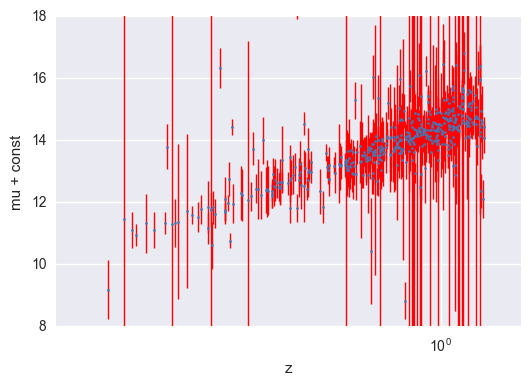

In [57]:
import gzip, cPickle
snFits = cPickle.load(gzip.GzipFile('snFits.p.gz'))

print len(snFits)
snf = [s for s in snFits.values() if s is not None]
print len(snf)
z = np.array([s.z for s in snf])
mu = np.array([s.mu for s in snf])
mu_var = mu.copy() #np.array([s.mu_var for s in snf])
for i,s in enumerate(snf):
    try:
        mu_var[i] = s.mu_var
    except:
        mu_var[i] = 999

z = z[(mu > 0) & (mu < 19)]
mu = mu[(mu > 0) & (mu < 19)]
mu_var = mu_var[(mu > 0) & (mu < 19)]
#plt.scatter(z, mu)
plt.errorbar(z, mu, yerr=np.sqrt(mu_var), fmt='o', ecolor='r', elinewidth=1, ms=2)
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('mu + const')
plt.xlim((0.2,1.4))
plt.ylim((8,18));